In [25]:
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns

# awaryjne pobranie danych do csv
import data_import
data_import.get_data()

sns.set()
matplotlib.rcParams['figure.figsize'] = (12, 7)
pd.set_option('display.float_format','{:.4f}'.format)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Wybór zmiennych ryzyka (Akcje TSMC i Samsunga)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


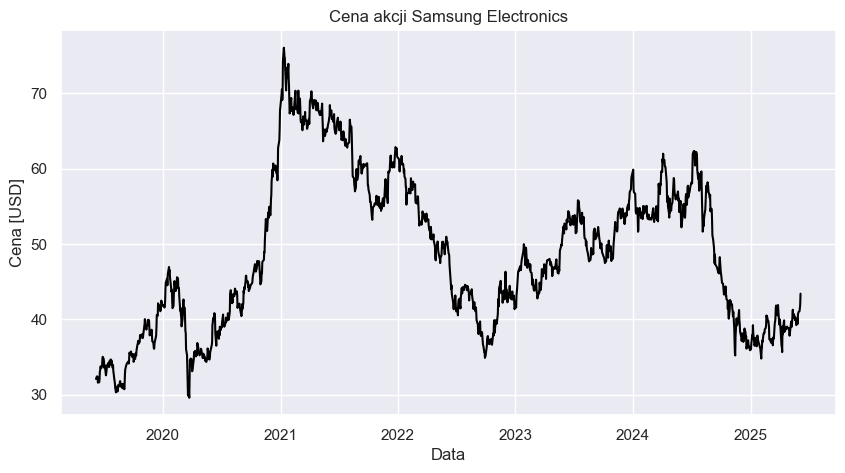

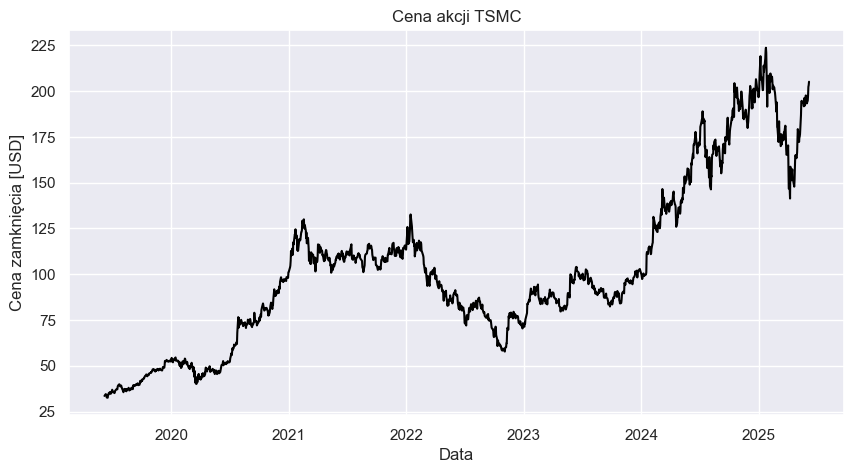

In [26]:
samsung_krw = yf.download('005930.KS', period='6y')['Close'].squeeze()
usd_krw = yf.download('KRW=X', period='6y')['Close'].squeeze()
tsmc_data = yf.download('TSM', period='6y')['Close'].squeeze()

common_index = samsung_krw.index.intersection(usd_krw.index)
samsung_krw_filtered = samsung_krw[common_index]
usd_krw_filtered = usd_krw[common_index]
samsung_usd = samsung_krw_filtered / usd_krw_filtered
samsung_usd_clean = samsung_usd.dropna()
samsung = samsung_usd_clean

plt.figure(figsize=(10, 5))
plt.plot(samsung, color='black')
plt.title('Cena akcji Samsung Electronics')
plt.ylabel('Cena [USD]')
plt.xlabel('Data')
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(tsmc_data.dropna(), color='black') 
plt.title('Cena akcji TSMC')
plt.ylabel('Cena zamknięcia [USD]')
plt.xlabel('Data')
plt.grid(True)
plt.show()

# Logarytmiczne Stopy zwrotu 

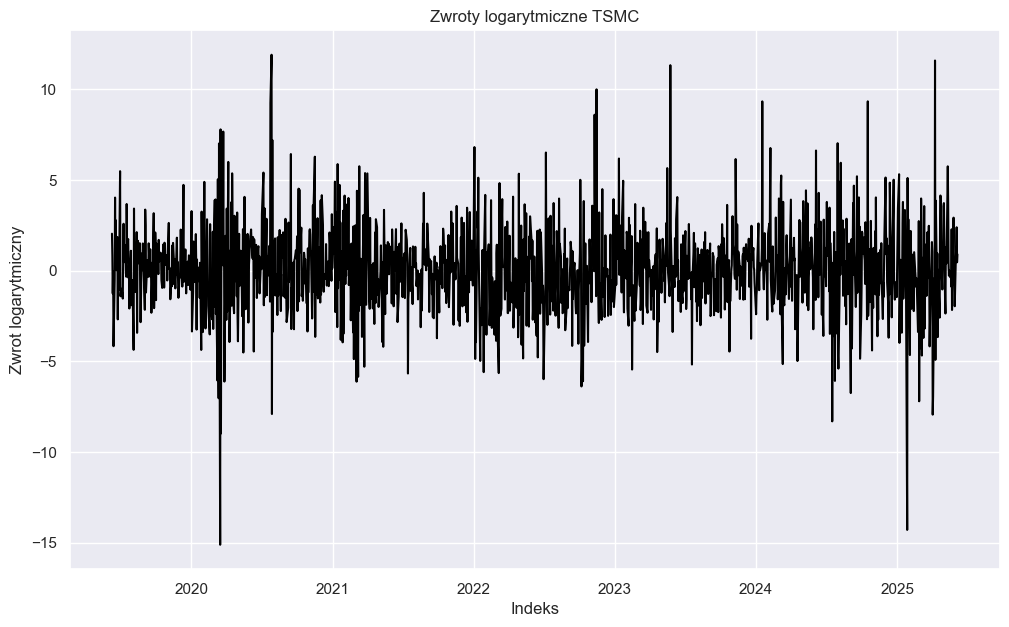

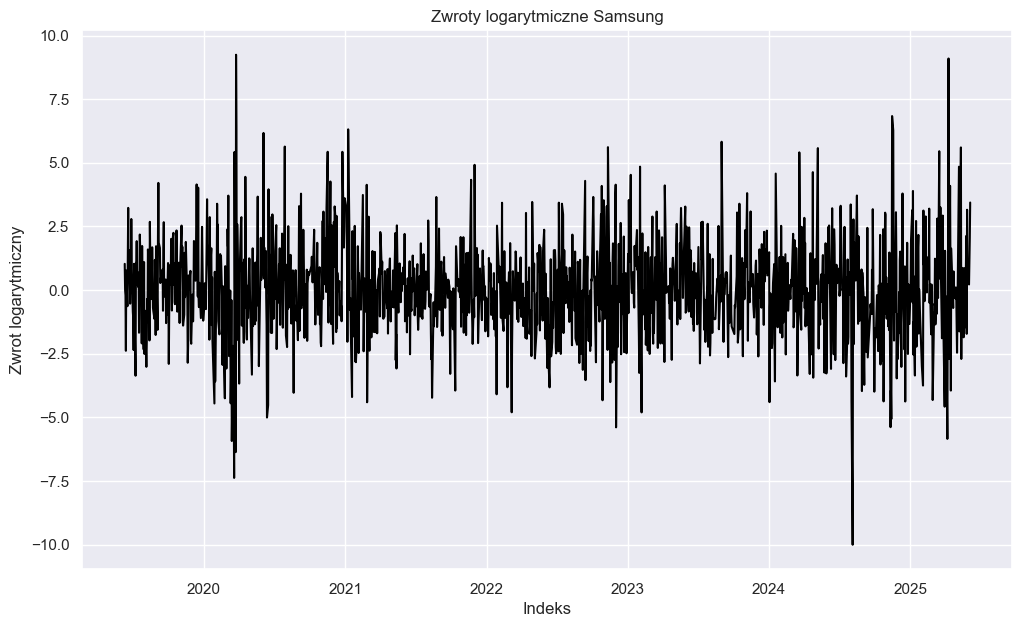

In [27]:
log_returns_samsung = np.log(samsung / samsung.shift(1)).dropna() * 100
log_returns_tsmc = np.log(tsmc_data / tsmc_data.shift(1)).dropna() * 100


plt.plot(log_returns_tsmc, color = 'black')
plt.title('Zwroty logarytmiczne TSMC')
plt.ylabel('Zwrot logarytmiczny')
plt.xlabel('Indeks')
plt.grid(True)
plt.show()

plt.plot(log_returns_samsung, color = 'black')
plt.title('Zwroty logarytmiczne Samsung')
plt.ylabel('Zwrot logarytmiczny')
plt.xlabel('Indeks')
plt.grid(True)
plt.show()

# 1. Średnie, odchylenia i korelacja dla zwrotów logarytmicznych

In [28]:
prices_df = pd.concat([samsung, tsmc_data], axis=1, join='inner')
prices_df.columns = ['Samsung_Price', 'TSMC_Price']
prices_df = prices_df.dropna()

combined_log_returns_df = np.log1p(prices_df.pct_change()).dropna()
data_comb = combined_log_returns_df.to_numpy()
print('\n---Stopy procentowe dzienne---\n')
print("TSMC:")
print(f"  Średnia: {log_returns_tsmc.mean():.2f}%")
print(f"  Odchylenie standardowe: {log_returns_tsmc.std():.2f}%")

print("\nSamsung:")
print(f"  Średnia: {log_returns_samsung.mean():.2f}%")
print(f"  Odchylenie standardowe: {log_returns_samsung.std():.2f}%")

print('\n---Stopy procentowe roczne---\n')
print("TSMC:")
print(f"  Średnia: {log_returns_tsmc.mean()*252:.2f}%")
print(f"  Odchylenie standardowe: {log_returns_tsmc.std()*np.sqrt(252):.2f}%")

print("\nSamsung:")
print(f"  Średnia: {log_returns_samsung.mean()*252:.2f}%")
print(f"  Odchylenie standardowe: {log_returns_samsung.std()*np.sqrt(252):.2f}%")

print('\n------')
print("\nKorelacja Logarytmicznych Stóp Zwrotu:")
correlation_matrix = combined_log_returns_df.corr()
correlation_value = correlation_matrix.loc['Samsung_Price', 'TSMC_Price']
print(f"  Korelacja między Samsungiem a TSMC: {correlation_value:.4f}")



---Stopy procentowe dzienne---

TSMC:
  Średnia: 0.12%
  Odchylenie standardowe: 2.41%

Samsung:
  Średnia: 0.02%
  Odchylenie standardowe: 1.87%

---Stopy procentowe roczne---

TSMC:
  Średnia: 30.28%
  Odchylenie standardowe: 38.27%

Samsung:
  Średnia: 5.18%
  Odchylenie standardowe: 29.62%

------

Korelacja Logarytmicznych Stóp Zwrotu:
  Korelacja między Samsungiem a TSMC: 0.1827


# Użycie klasy do portfela z Projektu 2

In [29]:
class Portfel:
    def __init__(self, data_comb, odset_tsmc: float = .5) -> None:
        self.odset_tsmc = odset_tsmc
        self.odset_smg = 1 - odset_tsmc
        self.log_tsmc = data_comb[:, 1]
        self.log_smg = data_comb[:, 0]

    @property
    def mean(self):
        return self.odset_tsmc * self.log_tsmc.mean() + self.odset_smg * self.log_smg.mean()

    @property
    def var(self):
        return (
            self.odset_tsmc**2 * self.log_tsmc.var() +
            self.odset_smg**2 * self.log_smg.var() +
            2 * self.odset_smg * self.odset_tsmc *
            self.log_smg.std() * self.log_tsmc.std() *
            np.corrcoef(self.log_smg[1:], self.log_tsmc[1:])[1, 0]
        )

In [30]:
data_comb = combined_log_returns_df.to_numpy()
portfel = Portfel(data_comb, odset_tsmc=0.5)
print("Dzienne:")
print(f"Oczekiwana dzienna stopa zwrotu portfela: {portfel.mean:.4f}")
print(f"Ryzyko dzienne portfela (odchylenie standardowe): {np.sqrt(portfel.var):.4f}")

print('\nRoczne:')
print(f"Oczekiwana roczna stopa zwrotu portfela: {252*portfel.mean:.4f}")
print(f"Ryzyko dzienne portfela (odchylenie standardowe): {np.sqrt(252* portfel.var):.4f}")

Dzienne:
Oczekiwana dzienna stopa zwrotu portfela: 0.0007
Ryzyko dzienne portfela (odchylenie standardowe): 0.0168

Roczne:
Oczekiwana roczna stopa zwrotu portfela: 0.1865
Ryzyko dzienne portfela (odchylenie standardowe): 0.2666


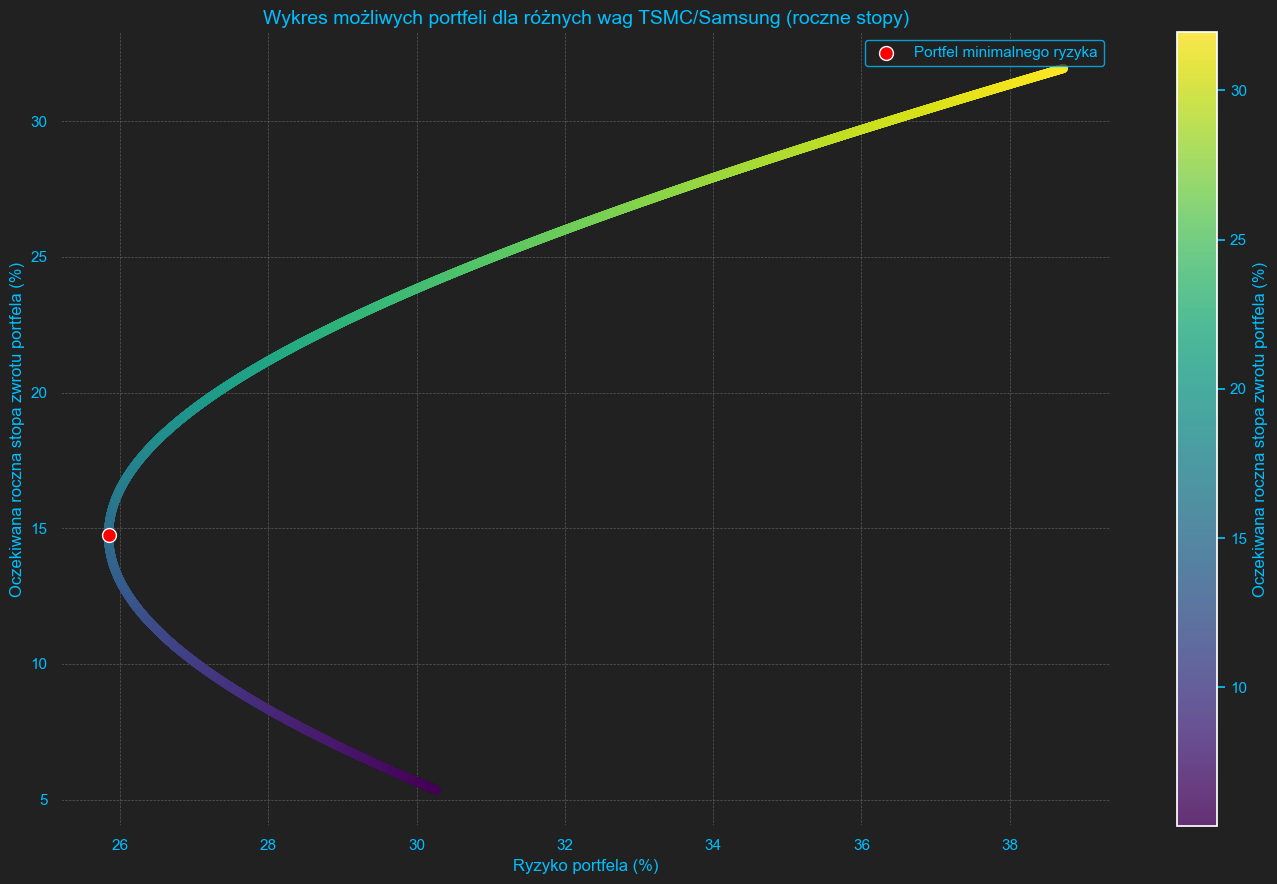

Najniższe ryzyko portfela (roczne): 25.85%
Wagi minimalnego ryzyka: TSMC = 35.32%, Samsung = 64.68%


In [31]:
kroki = np.linspace(0, 1, 10000)
srednie = []
ryzyka = []
min_risk = float('inf')
best_weight = None

for waga_tsmc in kroki:
    p = Portfel(data_comb, odset_tsmc=waga_tsmc)
    mean = p.mean * 252 * 100
    risk = np.sqrt(p.var * 252) * 100
    srednie.append(mean)
    ryzyka.append(risk)

    if risk < min_risk:
        min_risk = risk
        best_weight = waga_tsmc

srednie = np.array(srednie)
ryzyka = np.array(ryzyka)

fig, ax = plt.subplots(figsize=(14, 9))
fig.patch.set_facecolor('#212121')
ax.set_facecolor('#212121')

scatter = ax.scatter(ryzyka, srednie, c=srednie, cmap='viridis', marker='o', s=30, alpha=0.8)
cbar = plt.colorbar(scatter, ax=ax, label='Oczekiwana roczna stopa zwrotu portfela (%)')
cbar.ax.yaxis.label.set_color('deepskyblue')
cbar.ax.tick_params(colors='deepskyblue')

plt.title(f'Wykres możliwych portfeli dla różnych wag TSMC/Samsung (roczne stopy)', 
          color='deepskyblue', fontsize=14)
plt.xlabel('Ryzyko portfela (%)', color='deepskyblue')
plt.ylabel('Oczekiwana roczna stopa zwrotu portfela (%)', color='deepskyblue')

ax.tick_params(colors='deepskyblue')
ax.xaxis.label.set_color('deepskyblue')
ax.yaxis.label.set_color('deepskyblue')

ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.6)
ax.spines['bottom'].set_color('#212121')
ax.spines['left'].set_color('#212121')
ax.spines['top'].set_color('#212121')
ax.spines['right'].set_color('#212121')

ax.scatter(min_risk, srednie[kroki.tolist().index(best_weight)],
           color='red', label='Portfel minimalnego ryzyka', s=100, edgecolors='white', zorder=10)
ax.legend(facecolor='#212121', edgecolor='deepskyblue', labelcolor='deepskyblue')

plt.tight_layout()
plt.show()

print(f'Najniższe ryzyko portfela (roczne): {min_risk:.2f}%')
print(f'Wagi minimalnego ryzyka: TSMC = {best_weight:.2%}, Samsung = {1 - best_weight:.2%}')


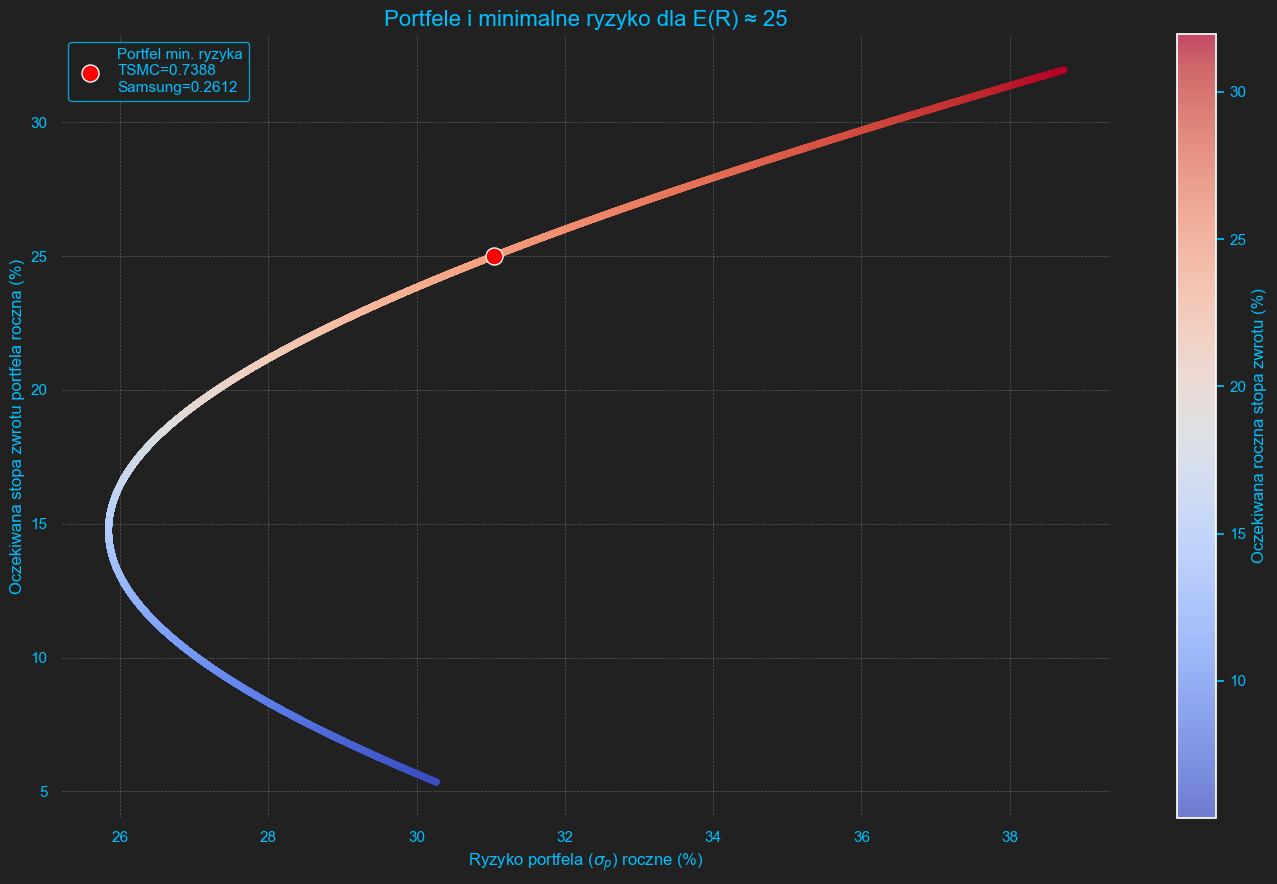

Znaleziono portfel o minimalnym ryzyku przy E(R) ≈ 25
Wagi: TSMC = 0.7388, Samsung = 0.2612
Ryzyko (σ) roczne: 31.0414


In [34]:
target_mean = 25
tolerance = 0.001

space = np.linspace(0, 1, 100000)

means = []
risks = []

best_risk = float('inf')
best_weight = None

for w in space:
    p = Portfel(data_comb, odset_tsmc=w)
    portfel_mean = p.mean * 252  * 100       # roczna stopa zwrotu
    portfel_risk = np.sqrt(p.var * 252)  * 100# roczne odchylenie standardowe
    means.append(portfel_mean)
    risks.append(portfel_risk)

    if abs(portfel_mean - target_mean) <= tolerance:
        if portfel_risk < best_risk:
            best_risk = portfel_risk
            best_weight = w

means = np.array(means)
risks = np.array(risks)

fig, ax = plt.subplots(figsize=(14,9))
fig.patch.set_facecolor('#212121')
ax.set_facecolor('#212121')

scatter = ax.scatter(
    risks,
    means,
    c=means,
    cmap='coolwarm',
    marker='o',
    s=15,
    alpha=0.7
)

cbar = plt.colorbar(scatter, ax=ax, label='Oczekiwana roczna stopa zwrotu (%)')
cbar.ax.yaxis.label.set_color('deepskyblue')
cbar.ax.tick_params(colors='deepskyblue')

plt.title(f'Portfele i minimalne ryzyko dla E(R) ≈ {target_mean}', color='deepskyblue', fontsize=16)
plt.xlabel('Ryzyko portfela ($\\sigma_p$) roczne (%)', color='deepskyblue')
plt.ylabel('Oczekiwana stopa zwrotu portfela roczna (%)', color='deepskyblue')

ax.tick_params(colors='deepskyblue')
ax.xaxis.label.set_color('deepskyblue')
ax.yaxis.label.set_color('deepskyblue')

ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.6)

ax.spines['bottom'].set_color('#212121')
ax.spines['left'].set_color('#212121')
ax.spines['top'].set_color('#212121')
ax.spines['right'].set_color('#212121')

if best_weight is not None:
    ax.scatter(best_risk, target_mean, color='red', edgecolor='white', s=150,
               label=f'Portfel min. ryzyka\nTSMC={best_weight:.4f}\nSamsung={1-best_weight:.4f}', zorder=10)
    ax.legend(facecolor='#212121', edgecolor='deepskyblue', labelcolor='deepskyblue')

plt.tight_layout()
plt.show()

if best_weight is not None:
    print(f'Znaleziono portfel o minimalnym ryzyku przy E(R) ≈ {target_mean}')
    print(f'Wagi: TSMC = {best_weight:.4f}, Samsung = {1 - best_weight:.4f}')
    print(f'Ryzyko (σ) roczne: {best_risk:.4f}')
else:
    print('Nie znaleziono portfela spełniającego warunek oczekiwanej stopy zwrotu.')


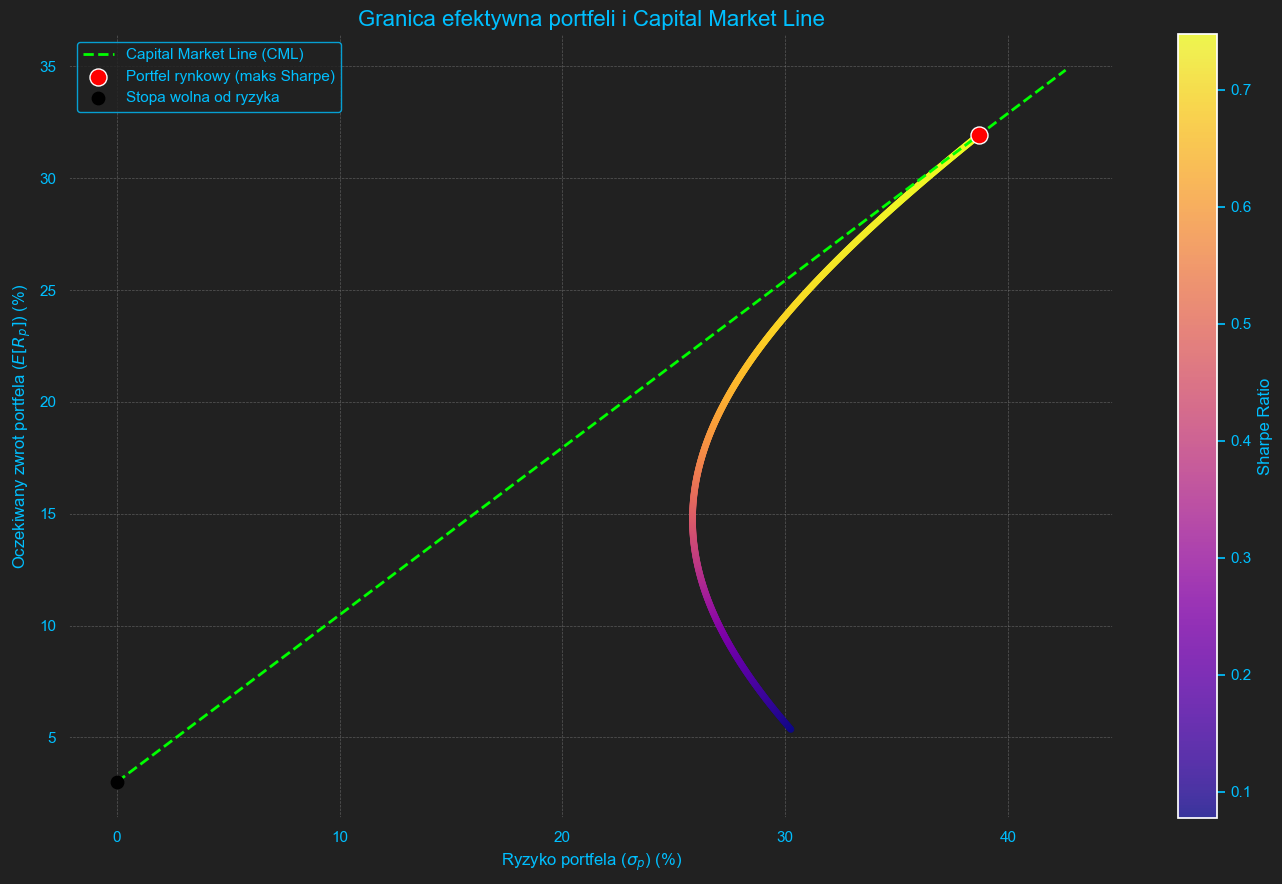

Portfel rynkowy (maks Sharpe ratio):
  Waga TSMC: 1.0000
  Waga Samsung: 0.0000
  Oczekiwany zwrot: 31.9465%
  Ryzyko (odchylenie std): 38.7257%
  Sharpe ratio: 0.7475


In [43]:
Rf = 3  # stopa wolna od ryzyka (roczna %)

space = np.linspace(0, 1, 1000)
means = []
risks = []
sharpes = []

for w in space:
    p = Portfel(data_comb, odset_tsmc=w)
    mean = p.mean * 252 * 100      # dzienna średnia na roczną
    risk = np.sqrt(p.var) * np.sqrt(252) * 100 # dzienna wariancja na roczną
    sharpe = (mean - Rf) / risk

    means.append(mean)
    risks.append(risk)
    sharpes.append(sharpe)

means = np.array(means)
risks = np.array(risks)
sharpes = np.array(sharpes)

max_sharpe_idx = np.argmax(sharpes)
best_weight = space[max_sharpe_idx]
max_sharpe = sharpes[max_sharpe_idx]
best_mean = means[max_sharpe_idx]
best_risk = risks[max_sharpe_idx]

fig, ax = plt.subplots(figsize=(14,9))

fig.patch.set_facecolor('#212121')
ax.set_facecolor('#212121')

scatter = ax.scatter(
    risks,
    means,
    c=sharpes,
    cmap='plasma',
    marker='o',
    s=15,
    alpha=0.8
)

cbar = plt.colorbar(scatter, ax=ax, label='Sharpe Ratio')
cbar.ax.yaxis.label.set_color('deepskyblue')
cbar.ax.tick_params(colors='deepskyblue')

plt.title('Granica efektywna portfeli i Capital Market Line', color='deepskyblue', fontsize=16)
plt.xlabel('Ryzyko portfela ($\\sigma_p$) (%)', color='deepskyblue')
plt.ylabel('Oczekiwany zwrot portfela ($E[R_p]$) (%)', color='deepskyblue')

ax.tick_params(colors='deepskyblue')
ax.xaxis.label.set_color('deepskyblue')
ax.yaxis.label.set_color('deepskyblue')

ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.6)

ax.spines['bottom'].set_color('#212121')
ax.spines['left'].set_color('#212121')
ax.spines['top'].set_color('#212121')
ax.spines['right'].set_color('#212121')

# Capital Market Line (CML)
slope = (best_mean - Rf) / best_risk
cml_x = np.linspace(0, max(risks)*1.1, 100)
cml_y = Rf + slope * cml_x
ax.plot(cml_x, cml_y, label='Capital Market Line (CML)', color='lime', linestyle='--', linewidth=2)

# Najlepszy portfel
ax.scatter(best_risk, best_mean, color='red', edgecolor='white', s=150, label='Portfel rynkowy (maks Sharpe)', zorder=10)
ax.scatter(0, Rf, color='black', label='Stopa wolna od ryzyka', s=80, zorder=10)

ax.legend(facecolor='#212121', edgecolor='deepskyblue', labelcolor='deepskyblue')

plt.tight_layout()
plt.show()

print(f'Portfel rynkowy (maks Sharpe ratio):')
print(f'  Waga TSMC: {best_weight:.4f}')
print(f'  Waga Samsung: {1 - best_weight:.4f}')
print(f'  Oczekiwany zwrot: {best_mean:.4f}%')
print(f'  Ryzyko (odchylenie std): {best_risk:.4f}%')
print(f'  Sharpe ratio: {max_sharpe:.4f}')

